### Finding the map given an image

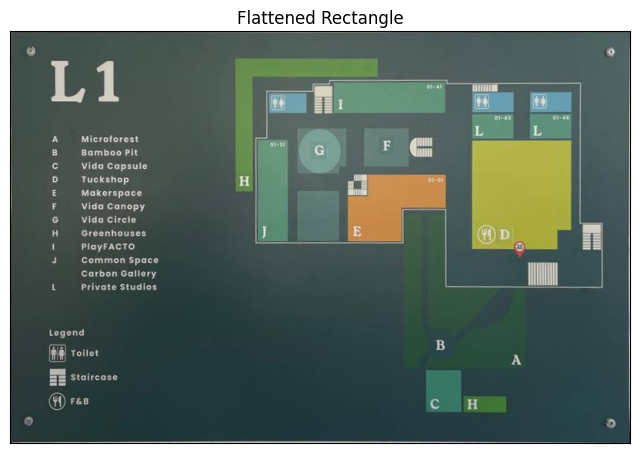

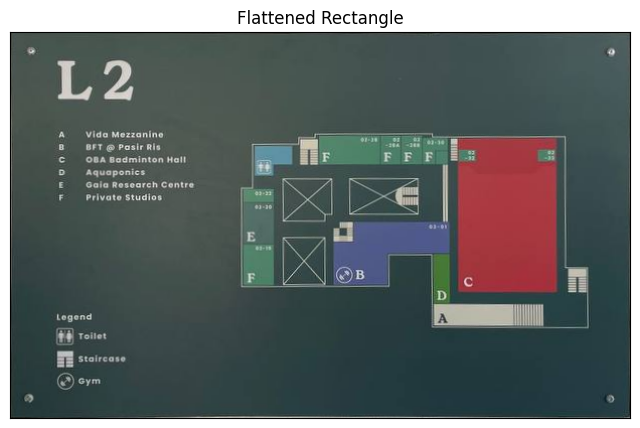

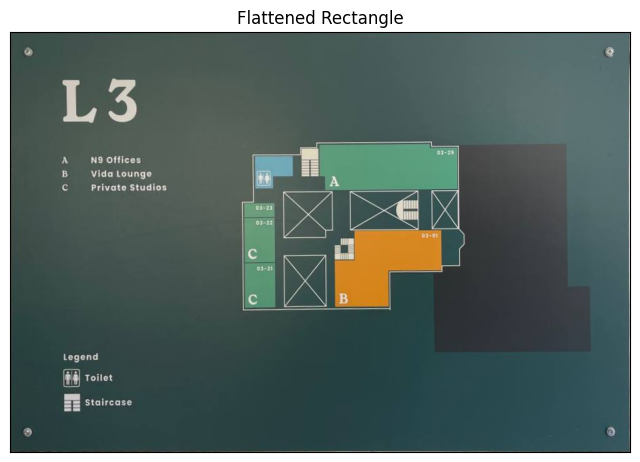

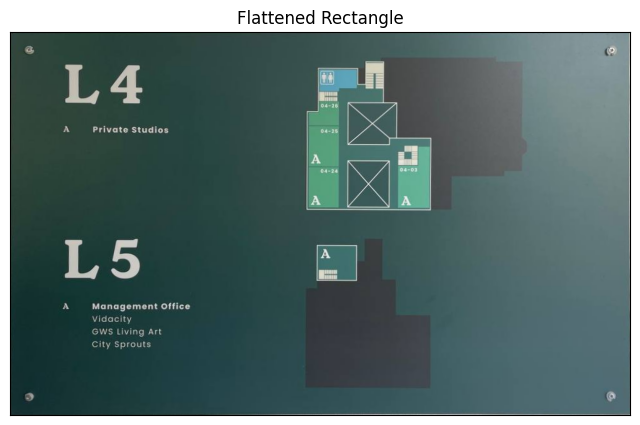

In [26]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

def order_points(pts):
    # Order the points in the following order: top-left, top-right, bottom-right, bottom-left.
    rect = np.zeros((4, 2), dtype="float32")
    
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # top-left
    rect[2] = pts[np.argmax(s)]  # bottom-right

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # top-right
    rect[3] = pts[np.argmax(diff)]  # bottom-left
    
    return rect

def four_point_transform(image, pts):
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped


def draw_dots_on_largest_rectangle(source):
    """
    Finds the largest rectangle in 'image' and draws red dots on its corners.
    Modifies the image in-place and returns it.
    """
    image = cv2.imread(source)
    if image is None:
        return None
    
    rect = find_largest_quadrilateral(image)
    if rect is not None:
        # rect has shape (4,1,2)
        corners = rect.reshape((4, 2))  # Now it's (4,2)
        corners = order_points(corners)
        # Then draw your circles
        for (x, y) in corners:
            cv2.circle(image, (int(x), int(y)), 5, (0, 0, 255), -1)
    return image

def find_largest_quadrilateral(image):
    """
    Finds the largest 4-sided contour (quadrilateral) in the image.
    Returns the approximated contour (4 points) if found, otherwise returns None.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Edge detection with Canny
    edged = cv2.Canny(blurred, 50, 200)
    
    # Use a morphological closing to help join broken edges
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
    
    # Find contours in the edged image
    contours, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    largest_area = 0
    best_approx = None
    # Loop over the contours
    for cnt in contours:
        # Approximate the contour to a polygon
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        
        # Check if it has 4 points
        if len(approx) == 4:
            area = cv2.contourArea(approx)
            if area > largest_area:
                largest_area = area
                best_approx = approx
                
    return best_approx


def process_image(source):
    image = cv2.imread(source)
    if image is None:
        print("Could not open image:", source)
        return None
    else:
        rect = find_largest_quadrilateral(image)
        if rect is not None:
            # rect has shape (4,1,2)
            corners = rect.reshape((4, 2))  # Now it's (4,2)
            corners = order_points(corners)
            transformed_image = four_point_transform(image, corners)
            return transformed_image
    

def batch_process(path, show=False):
    warped_images = []
    dotted_images = []
    for image in os.listdir(path):
        source = os.path.join(path, image)
        dotted_image = draw_dots_on_largest_rectangle(source)
        warped_image = process_image(source)

        warped_images.append(warped_image)
        dotted_images.append(dotted_image)

    if show:
        for image in warped_images:
            if image is not None:
                # plt.subplot(222)
                plt.figure(figsize=(8, 6))
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.title('Flattened Rectangle')
                plt.xticks([]), plt.yticks([])
                plt.show()
        # for image in dotted_images:
        #     if image is not None:
        #         plt.subplot(122)
        #         plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        #         plt.title('Flattened Rectangle')
        #         plt.xticks([]), plt.yticks([])
        #         plt.show()
    return warped_images



focused_images = batch_process("floorplans", show=True)

### Extracting out largest regions

(308, 487)


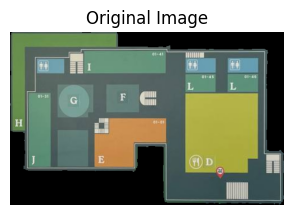

308 487
(204, 354)


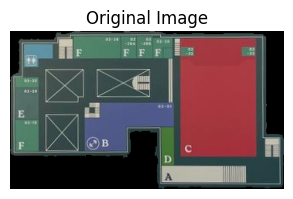

204 354
(279, 365)


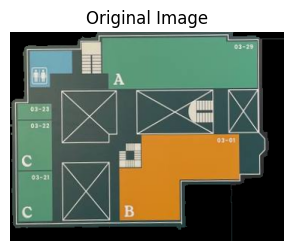

279 365
(250, 220)


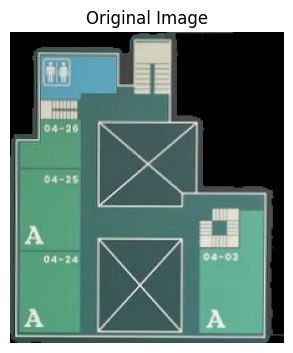

250 220


In [27]:
def extractLargestRegion(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 5)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = filter_contours(contours, image.shape[0] * image.shape[1])
    if filtered_contours:
        # Find the largest contour by area
        largest_contour = max(filtered_contours, key=cv2.contourArea)

        # Create a mask for the largest region
        mask = np.zeros_like(gray)
        cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
        mask_colored = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

        # Extract the region
        largest_region = cv2.bitwise_and(image, mask_colored)

        # Find bounding box around the extracted region
        x, y, w, h = cv2.boundingRect(largest_contour)
        cropped_region = largest_region[y:y+h, x:x+w]  # Crop to remove black areas

        return cropped_region
    else:
        print("No valid large contours detected.")


def plot_image(image):
    print(image.shape[:2])
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
        


def filter_contours(contours, image_area):
    valid_contours = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < image_area * 0.01:
            continue
            
        x,y,w,h = cv2.boundingRect(cnt)
        aspect_ratio = float(w)/h 
        if not (0.3 < aspect_ratio < 3.5):
            continue

        hull = cv2.convexHull(cnt)
        hull_area =  cv2.contourArea(hull)
        solidarity = area/float(hull_area) if hull_area > 0 else 0
        if solidarity < 0.6:
            continue

        valid_contours.append(cnt)

    return valid_contours

extracted_floorPlans = []
for image in focused_images:
    # print(image)
    extracted_floorPlans.append(extractLargestRegion(image))


for image in extracted_floorPlans:
    plot_image(image)
    height, width = image.shape[:2]
    print(height, width)

### Raw contour lines

(308, 487)


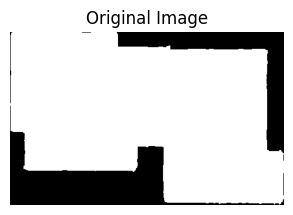

308 487
(204, 354)


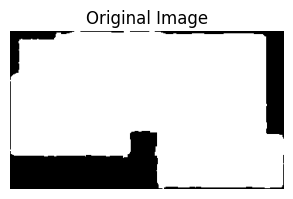

204 354
(279, 365)


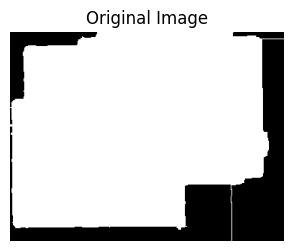

279 365
(250, 220)


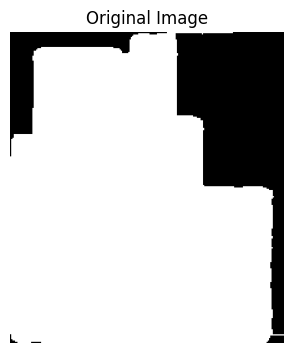

250 220


In [ ]:
def extract_largest_contour(image):
    """
    Extracts only the largest external contour line from an image.
    Returns a binary mask with just the contour.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold to create a binary image
    _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Ensure we found at least one contour
    if not contours:
        print("No contours found.")
        return None

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Create a blank mask
    mask = np.zeros_like(gray)

    # Draw only the contour outline
    cv2.drawContours(mask, [largest_contour], -1, 255, thickness=2)  # Adjust thickness if needed

    return mask

contour_maps = []
for image in extracted_floorPlans:
    # plot_image(image)
    # height, width = image.shape[:2]
    # print(height, width)
    mask = extract_largest_contour(image)
    plot_image(mask)
    height, width = mask.shape[:2]
    print(height, width)
    contour_maps.append(mask)

308 487
204 354
Images are different sizes! Overlaying at the top-left corner.
(308, 487)


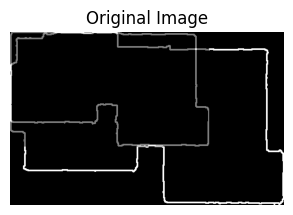

In [29]:
def overlay_images(background, overlay, alpha=0.5):
    """
    Overlays 'overlay' on top of 'background' with transparency blending without modifying originals.
    
    Parameters:
        background: The base image.
        overlay: The image to be placed on top.
        alpha: Transparency level (0 = only background, 1 = only overlay).

    Returns:
        A new image with the overlay applied.
    """
    # Make a copy of the background to prevent modifying the original
    result = background.copy()

    # Get dimensions
    bg_h, bg_w = background.shape[:2]
    ov_h, ov_w = overlay.shape[:2]
    print(bg_h, bg_w)
    print(ov_h, ov_w)

    # Ensure overlay fits within background
    if (bg_h, bg_w) != (ov_h, ov_w):
        print("Images are different sizes! Overlaying at the top-left corner.")
        x_offset, y_offset = 0, 0  # Place overlay at top-left corner
    else:
        x_offset, y_offset = 0, 0  # Align perfectly if same size

    # Blend images with transparency
    blended = cv2.addWeighted(result[y_offset:y_offset+ov_h, x_offset:x_offset+ov_w], 1 - alpha, 
                              overlay, alpha, 0)

    # Place blended overlay back onto the result image
    result[y_offset:y_offset+ov_h, x_offset:x_offset+ov_w] = blended

    return result


image = overlay_images(contour_maps[0], contour_maps[1])
plot_image(image)

(308, 487)


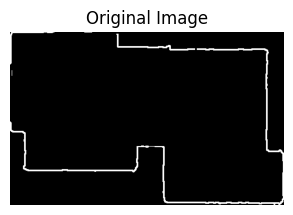

4312

In [30]:
def pad_to_match(image1, image2):
    """
    Pads the smaller image with black pixels so both images have the same size.
    """
    h1, w1 = image1.shape
    h2, w2 = image2.shape

    max_h, max_w = max(h1, h2), max(w1, w2)

    padded1 = np.zeros((max_h, max_w), dtype=np.uint8)
    padded2 = np.zeros((max_h, max_w), dtype=np.uint8)

    # Place the original images at the top-left corner of the padded images
    padded1[:h1, :w1] = image1
    padded2[:h2, :w2] = image2

    return padded1, padded2

def subtract_image(image1, image2):
    """
    Subtracts image2 from image1, ensuring both images have the same size.
    If image2 is smaller, black padding is added to match image1.
    """
    image1, image2 = pad_to_match(image1, image2)
    return cv2.subtract(image1, image2)  # Ensure no underflow

# Example Usage
image1 = contour_maps[0]
image2 = contour_maps[1]

import cv2
import numpy as np

def count_white_pixels(image):
    """
    Counts the number of white pixels in a binary image.
    """
    # Convert to grayscale if it's a color image
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the image to ensure binary format (white = 255, black = 0)
    _, binary = cv2.threshold(image, 1, 255, cv2.THRESH_BINARY)

    # Count the number of white pixels
    white_pixel_count = np.sum(binary == 255)

    return white_pixel_count
    

image3 = subtract_image(image1, image2)
plot_image(image3)
count_white_pixels(image3)

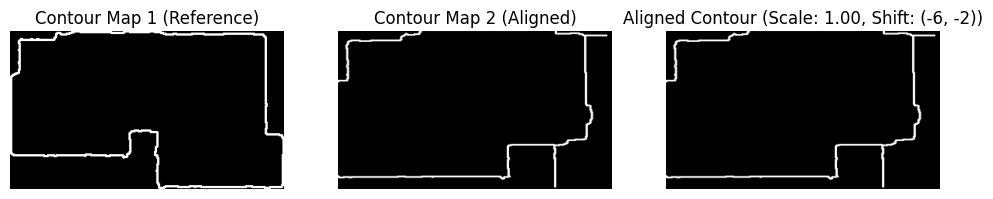

Best Scale: 1.0000000000000002, Best Shift: (-6, -2)
204 354
204 354
(204, 354)


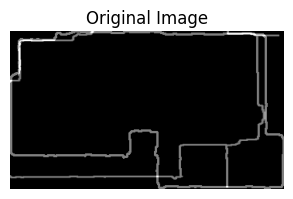

In [31]:
import cv2
import numpy as np

def find_shift_scale(image1, image2, scale_range=(0.7, 1.5), step_size=0.05, shift_range=50):
    """
    Finds the best scale and shift (dx, dy) to minimize white pixels after subtraction.
    """
    best_score = np.inf  # We want to minimize white pixels
    best_params = (1.0, (0, 0))
    best_resized = image2

    for scale in np.arange(scale_range[0], scale_range[1], step_size):
        resized2 = cv2.resize(image2, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)

        for dy in range(-shift_range, shift_range, 2):  # Search finer shifts
            for dx in range(-shift_range, shift_range, 2):
                # Shift the image
                shifted = apply_shift(resized2, dx, dy, image1.shape)

                # Subtract and count white pixels
                diff_image = subtract_image(image1, shifted)
                white_pixel_count = count_white_pixels(diff_image)

                # Minimize white pixels
                if white_pixel_count < best_score:
                    best_score = white_pixel_count
                    best_params = (scale, (dx, dy))
                    best_resized = resized2

    return best_params[0], best_params[1], best_resized

def apply_shift(image, shift_x, shift_y, target_shape):
    """
    Shifts an image by (dx, dy) while ensuring it does not go out of bounds.
    """
    h, w = image.shape
    target_h, target_w = target_shape

    shifted_canvas = np.zeros((target_h, target_w), dtype=np.uint8)

    start_x = max(0, shift_x)
    start_y = max(0, shift_y)
    end_x = min(start_x + w, target_w)
    end_y = min(start_y + h, target_h)

    src_x = max(0, -shift_x)
    src_y = max(0, -shift_y)
    src_w = min(end_x - start_x, w - src_x)
    src_h = min(end_y - start_y, h - src_y)

    if src_w > 0 and src_h > 0:
        shifted_canvas[start_y:start_y + src_h, start_x:start_x + src_w] = image[src_y:src_y + src_h, src_x:src_x + src_w]

    return shifted_canvas

# Example Usage
image1 = contour_maps[1]  # Reference contour map
image2 = contour_maps[2]  # Contour map to align

best_scale, best_shift, best_resized = find_shift_scale(image1, image2)

# Apply best scale
image2 = cv2.resize(best_resized, (image1.shape[1], image1.shape[0]), interpolation=cv2.INTER_LINEAR)

# Apply best shift
shift_x, shift_y = best_shift
image2 = apply_shift(image2, shift_x, shift_y, image1.shape)

# Display results
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.title("Contour Map 1 (Reference)")
plt.imshow(image1, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Contour Map 2 (Aligned)")
plt.imshow(image2, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title(f"Aligned Contour (Scale: {best_scale:.2f}, Shift: {best_shift})")
plt.imshow(image2, cmap="gray")
plt.axis("off")

plt.show()

print(f"Best Scale: {best_scale}, Best Shift: {best_shift}")

# Do not modify the below, it is for me to check the output 
overlayed = overlay_images(image1, image2)
plot_image(overlayed)

### trying with filled up images instead

(308, 487)


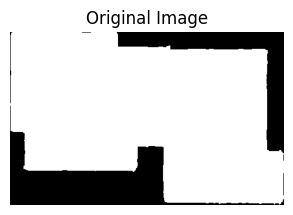

Contour Map Size: 308x487
(204, 354)


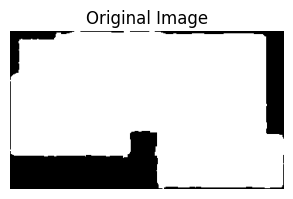

Contour Map Size: 204x354
(279, 365)


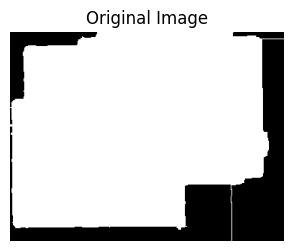

Contour Map Size: 279x365
(250, 220)


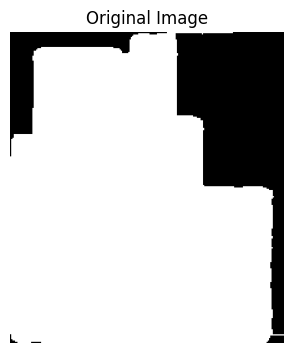

Contour Map Size: 250x220


In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_filled_largest_contour(image):
    """
    Extracts the largest external contour and fills its interior.
    Returns a binary mask with the filled contour.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold to create a binary image
    _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Ensure we found at least one contour
    if not contours:
        print("No contours found.")
        return None

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Create a blank mask
    mask = np.zeros_like(gray)

    # Draw and fill the contour
    cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)  # Fill inside

    return mask

filled_contour_maps = []
for image in extracted_floorPlans:
    mask = extract_filled_largest_contour(image)
    
    # Display the filled contour
    plot_image(mask)

    # Print dimensions
    height, width = mask.shape[:2]
    print(f"Contour Map Size: {height}x{width}")

    filled_contour_maps.append(mask)

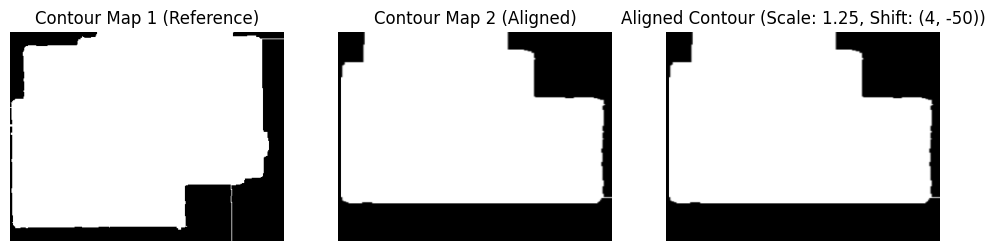

Best Scale: 1.2500000000000004, Best Shift: (4, -50)
279 365
279 365
(279, 365)


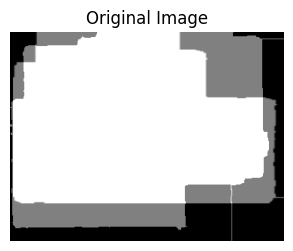

In [33]:
import cv2
import numpy as np

def find_shift_scale(image1, image2, scale_range=(0.7, 2.0), step_size=0.05, shift_range=50, scale_weight=0.1):
    """
    Finds the best scale and shift (dx, dy) by considering both:
        - image1 - image2 (white pixels after subtraction)
        - image2 - image1 (extra areas in image1)
    The goal is to minimize both extra areas while maximizing scale.
    """
    best_score = np.inf  # Lower score is better
    best_params = (1.0, (0, 0))
    best_resized = image2

    for scale in np.arange(scale_range[0], scale_range[1], step_size):
        resized2 = cv2.resize(image2, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)

        for dy in range(-shift_range, shift_range, 2):  # Finer shifts
            for dx in range(-shift_range, shift_range, 2):
                # Shift the resized image
                shifted = apply_shift(resized2, dx, dy, image1.shape)

                # Compute white pixels in both directions
                diff1 = subtract_image(image1, shifted)  # image1 - image2
                diff2 = subtract_image(shifted, image1)  # image2 - image1
                white_pixels1 = count_white_pixels(diff1)
                white_pixels2 = count_white_pixels(diff2)

                # Compute final score (lower is better)
                score = (white_pixels1 + white_pixels2) - scale_weight * scale  # Higher scale reduces score

                # Keep the best transformation
                if score < best_score:
                    best_score = score
                    best_params = (scale, (dx, dy))
                    best_resized = resized2

    return best_params[0], best_params[1], best_resized

def apply_shift(image, shift_x, shift_y, target_shape):
    """
    Shifts an image by (dx, dy) while ensuring it does not go out of bounds.
    """
    h, w = image.shape
    target_h, target_w = target_shape

    shifted_canvas = np.zeros((target_h, target_w), dtype=np.uint8)

    start_x = max(0, shift_x)
    start_y = max(0, shift_y)
    end_x = min(start_x + w, target_w)
    end_y = min(start_y + h, target_h)

    src_x = max(0, -shift_x)
    src_y = max(0, -shift_y)
    src_w = min(end_x - start_x, w - src_x)
    src_h = min(end_y - start_y, h - src_y)

    if src_w > 0 and src_h > 0:
        shifted_canvas[start_y:start_y + src_h, start_x:start_x + src_w] = image[src_y:src_y + src_h, src_x:src_x + src_w]

    return shifted_canvas

# Example Usage
image1 = filled_contour_maps[2]  # Reference contour map
image2 = filled_contour_maps[3]  # Contour map to align

best_scale, best_shift, best_resized = find_shift_scale(image1, image2)

# Apply best scale
image2 = cv2.resize(best_resized, (image1.shape[1], image1.shape[0]), interpolation=cv2.INTER_LINEAR)

# Apply best shift
shift_x, shift_y = best_shift
image2 = apply_shift(image2, shift_x, shift_y, image1.shape)

# Display results
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.title("Contour Map 1 (Reference)")
plt.imshow(image1, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Contour Map 2 (Aligned)")
plt.imshow(image2, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title(f"Aligned Contour (Scale: {best_scale:.2f}, Shift: {best_shift})")
plt.imshow(image2, cmap="gray")
plt.axis("off")

plt.show()

print(f"Best Scale: {best_scale}, Best Shift: {best_shift}")

# Do not modify the below, it is for me to check the output 
overlayed = overlay_images(image1, image2)
plot_image(overlayed)


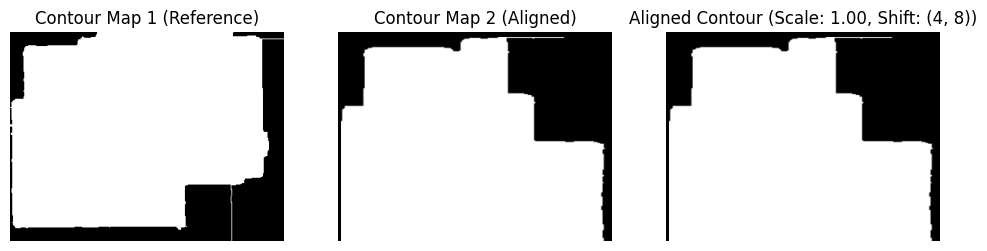

Best Scale: 1.0000000000000002, Best Shift: (4, 8)
279 365
279 365
(279, 365)


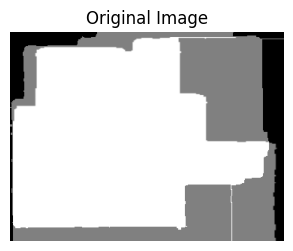

In [34]:
import cv2
import numpy as np

def find_shift_scale(image1, image2, scale_range=(0.7, 2.0), step_size=0.05, shift_range=50, scale_weight=0.05, overhang_penalty=5.0):
    """
    Finds the best scale and shift (dx, dy) with:
        - Heavy penalty for overhanging pixels (image2 extending beyond image1).
        - Incentive for maximizing scale, but much weaker than avoiding overhang.
    """
    best_score = np.inf  # Lower score is better
    best_params = (1.0, (0, 0))
    best_resized = image2

    for scale in np.arange(scale_range[0], scale_range[1], step_size):
        resized2 = cv2.resize(image2, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)

        for dy in range(-shift_range, shift_range, 2):  # Finer shifts
            for dx in range(-shift_range, shift_range, 2):
                # Shift the resized image
                shifted = apply_shift(resized2, dx, dy, image1.shape)

                # Compute white pixels in both directions
                diff1 = subtract_image(image1, shifted)  # image1 - image2 (extra in image2)
                diff2 = subtract_image(shifted, image1)  # image2 - image1 (overhang)
                white_pixels1 = count_white_pixels(diff1)
                white_pixels2 = count_white_pixels(diff2)

                # **Overhang penalty:** Punish white pixels in image2 - image1 heavily
                penalty = white_pixels2 * overhang_penalty

                # Compute final score (lower is better)
                score = (white_pixels1 + penalty) - scale_weight * scale  # Higher scale slightly reduces score

                # Keep the best transformation
                if score < best_score:
                    best_score = score
                    best_params = (scale, (dx, dy))
                    best_resized = resized2

    return best_params[0], best_params[1], best_resized

def apply_shift(image, shift_x, shift_y, target_shape):
    """
    Shifts an image by (dx, dy) while ensuring it does not go out of bounds.
    """
    h, w = image.shape
    target_h, target_w = target_shape

    shifted_canvas = np.zeros((target_h, target_w), dtype=np.uint8)

    start_x = max(0, shift_x)
    start_y = max(0, shift_y)
    end_x = min(start_x + w, target_w)
    end_y = min(start_y + h, target_h)

    src_x = max(0, -shift_x)
    src_y = max(0, -shift_y)
    src_w = min(end_x - start_x, w - src_x)
    src_h = min(end_y - start_y, h - src_y)

    if src_w > 0 and src_h > 0:
        shifted_canvas[start_y:start_y + src_h, start_x:start_x + src_w] = image[src_y:src_y + src_h, src_x:src_x + src_w]

    return shifted_canvas

# Example Usage
image1 = filled_contour_maps[2]  # Reference contour map (Lower floor)
image2 = filled_contour_maps[3]  # Contour map to align (Higher floor)

best_scale, best_shift, best_resized = find_shift_scale(image1, image2)

# Apply best scale
image2 = cv2.resize(best_resized, (image1.shape[1], image1.shape[0]), interpolation=cv2.INTER_LINEAR)

# Apply best shift
shift_x, shift_y = best_shift
image2 = apply_shift(image2, shift_x, shift_y, image1.shape)

# Display results
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.title("Contour Map 1 (Reference)")
plt.imshow(image1, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Contour Map 2 (Aligned)")
plt.imshow(image2, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title(f"Aligned Contour (Scale: {best_scale:.2f}, Shift: {best_shift})")
plt.imshow(image2, cmap="gray")
plt.axis("off")

plt.show()

print(f"Best Scale: {best_scale}, Best Shift: {best_shift}")

# Do not modify the below, it is for me to check the output 
overlayed = overlay_images(image1, image2)
plot_image(overlayed)


### Trying with a pre choosen size of image

0
(308, 487)


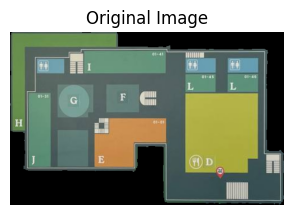

1
(277, 480)


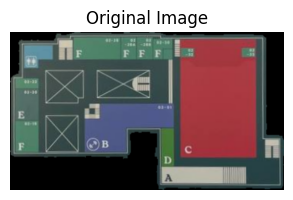

2
(215, 281)


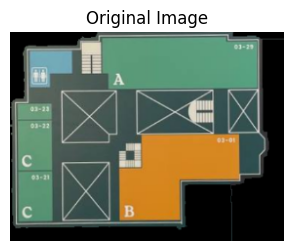

3
(215, 189)


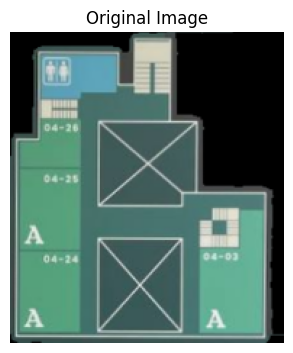

In [35]:
def scale_down_object(image1, image2, scale):
    h1, w1 = image1.shape[:2]  # Get height and width of image1
    h2, w2 = image2.shape[:2]  # Get height and width of image2

    # Step 1: Resize image2 to match the height of image1
    new_width = int(w2 * (h1 / h2))  # Preserve aspect ratio
    resized_image = cv2.resize(image2, (new_width, h1), interpolation=cv2.INTER_LINEAR)

    # Step 2: Apply the given scale factor
    final_width = int(new_width * scale)
    final_height = int(h1 * scale)
    scaled_image = cv2.resize(resized_image, (final_width, final_height), interpolation=cv2.INTER_LINEAR)

    # Step 3: Create a black canvas of the same size as image1, matching the number of channels
    if len(image1.shape) == 3:  # If image1 is color
        result = np.zeros((h1, w1, 3), dtype=np.uint8)
    else:  # If image1 is grayscale
        result = np.zeros((h1, w1), dtype=np.uint8)

    return scaled_image
import os
acutal_images = [] 
acutal_images.append(extracted_floorPlans[0])
acutal_images.append(scale_down_object(extracted_floorPlans[0], extracted_floorPlans[1], 0.90))
acutal_images.append(scale_down_object(extracted_floorPlans[0], extracted_floorPlans[2], 0.70))
acutal_images.append(scale_down_object(extracted_floorPlans[0], extracted_floorPlans[3], 0.70))


for index, image in enumerate(acutal_images):
    print(index)
    plot_image(image)
    path = "generated/"
    cv2.imwrite(os.path.join(path , f"{index}.jpg"), image)



#### Instead of actually getting the images from the inside, we going to just get input images

(308, 487)


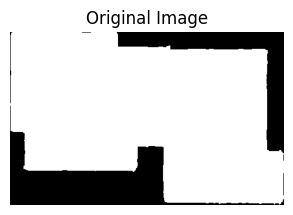

Contour Map Size: 308x487
(277, 480)


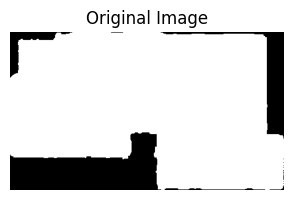

Contour Map Size: 277x480
(215, 281)


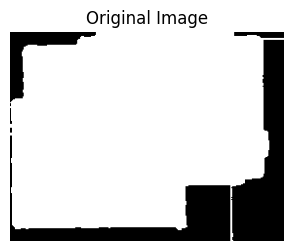

Contour Map Size: 215x281
(215, 189)


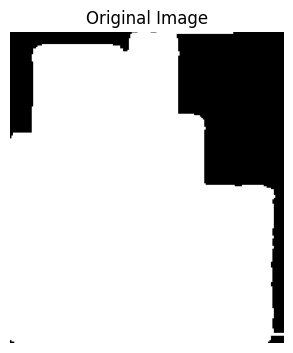

Contour Map Size: 215x189


In [ ]:
filled_contour_maps = []
for image in acutal_images:
    mask = extract_filled_largest_contour(image)
    
    # Display the filled contour
    plot_image(mask)

    # Print dimensions
    height, width = mask.shape[:2]
    print(f"Contour Map Size: {height}x{width}")

    filled_contour_maps.append(mask)

In [37]:
def creating_padded_image(ref_image, input_image, offsetx, offsety):
    heightRef, widthRef = ref_image.shape[:2]
    height, width = input_image.shape[:2]
    # print(widthRef, heightRef)
    # print(width, height)
    if width + offsetx > widthRef or height + offsety > heightRef: 
        return None
    leftOffset = offsetx
    rightOffset = widthRef - offsetx - width
    topOffset = offsety
    bottomOffset = heightRef - offsety - height
    # print(type(ref_image))
    dst = cv2.copyMakeBorder(input_image, topOffset, bottomOffset, leftOffset, rightOffset, cv2.BORDER_CONSTANT, (0,0,0))
    # plot_image(dst)
    return dst


image3 = creating_padded_image(acutal_images[0],acutal_images[1], 7, 31)


(308, 487)


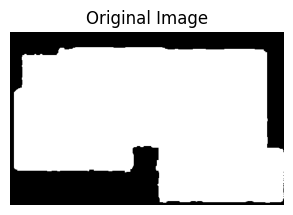

True

In [55]:
def finding_ideal(image1, image2):
    widthRef, heightRef = image1.shape[:2]
    width, height = image2.shape[:2]
    # print(widthRef, heightRef)
    # print(width, height)
    numberOfPixels = np.inf
    output = None
    for i in range(heightRef- height + 1):
        for j in range(widthRef - width + 1):
            # print(j,i)
            padded_image_2 = creating_padded_image(image1, image2, i, j)
            subtracted_image = subtract_image(image1, padded_image_2)
            pixels = count_white_pixels(subtracted_image)
            if pixels < numberOfPixels:
                output = padded_image_2
                numberOfPixels = pixels
                # plot_image(subtracted_image)
    
    return output


image = finding_ideal(filled_contour_maps[0],filled_contour_maps[1])
plot_image(image)
path="generated/"
cv2.imwrite(os.path.join(path , f"template.jpg"), image)


What the ding dong, the image is distored, doesn't matter the overlay thing is not correct logic

(308, 487)


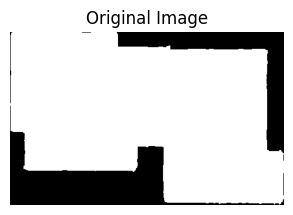

(308, 487)


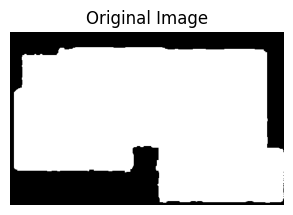

(308, 487)


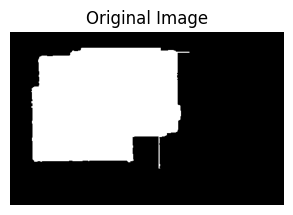

(308, 487)


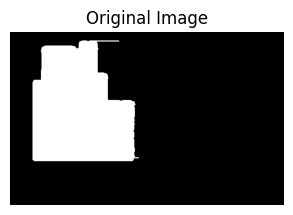

In [56]:
def formingBuilding(images):
    """
    Assuming input is grayscalled cropped out images of the floorplan
    """
    floorPlan = []
    for index, image in enumerate(images):
        if index == 0:
            floorPlan.append(image)
        else:
            referenceImage = floorPlan[-1]
            # plot_image(referenceImage)
            outputImage= finding_ideal(referenceImage, image)
            floorPlan.append(outputImage)
    return floorPlan


floors = formingBuilding(filled_contour_maps)
for image in floors:
    plot_image(image)

### Going back to the line thing

going to try the subtract out of copium

(308, 487)


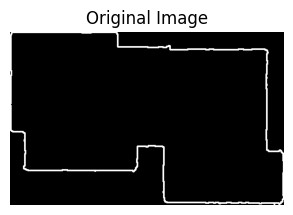

308 487
(277, 480)


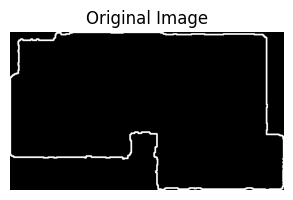

277 480
(215, 281)


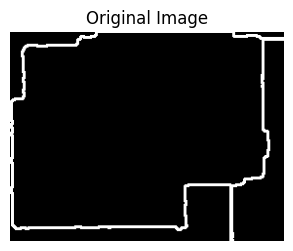

215 281
(215, 189)


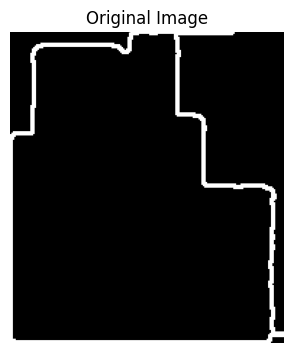

215 189


In [57]:
contour_maps = []
for image in acutal_images:
    # plot_image(image)
    # height, width = image.shape[:2]
    # print(height, width)
    mask = extract_largest_contour(image)
    plot_image(mask)
    height, width = mask.shape[:2]
    print(height, width)
    contour_maps.append(mask)

(308, 487)


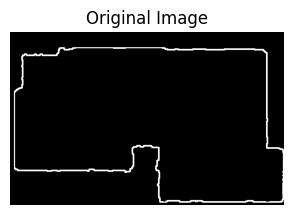

True

In [58]:
def finding_ideal_using_lines(ref_image, input_image):
    widthRef, heightRef = ref_image.shape[:2]
    width, height = input_image.shape[:2]
    # print(widthRef, heightRef)
    # print(width, height)
    numberOfPixels = np.inf
    output = None
    for i in range(heightRef- height + 1):
        for j in range(widthRef - width + 1):
            # print(j,i)
            padded_image_2 = creating_padded_image(ref_image, input_image, i, j)
            subtracted_image = subtract_image(ref_image, padded_image_2)
            pixels = count_white_pixels(subtracted_image)
            if pixels < numberOfPixels:
                output = padded_image_2
                numberOfPixels = pixels
                # plot_image(subtracted_image)
    
    return output


image = finding_ideal(contour_maps[0],contour_maps[1])
plot_image(image)
path="generated/"
cv2.imwrite(os.path.join(path , f"template.jpg"), image)


(308, 487)


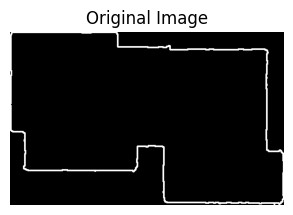

(308, 487)


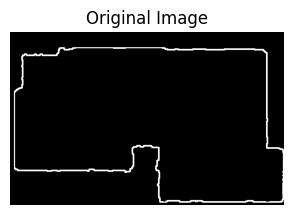

(308, 487)


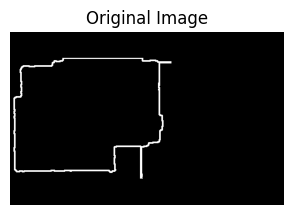

(308, 487)


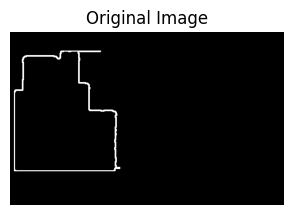

In [60]:
def formingBuilding(images):
    """
    Assuming input is grayscalled cropped out images of the floorplan
    """
    floorPlan = []
    for index, image in enumerate(images):
        if index == 0:
            floorPlan.append(image)
        else:
            referenceImage = floorPlan[-1]
            # plot_image(referenceImage)
            outputImage= finding_ideal_using_lines(referenceImage, image)
            floorPlan.append(outputImage)
    return floorPlan


floors = formingBuilding(contour_maps)
for image in floors:
    plot_image(image)

Turns out I forget to update the pixel number hehe

### Rewriting things to be a neat class

0
(308, 487)


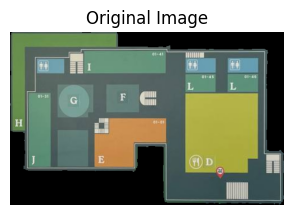

1
(277, 480)


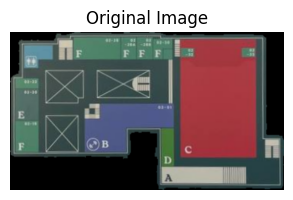

2
(215, 281)


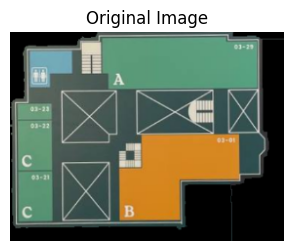

3
(215, 189)


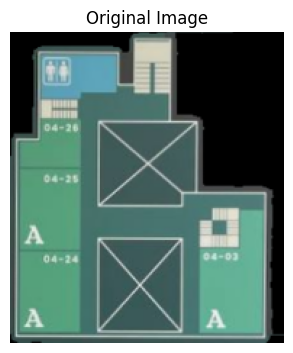

In [63]:
def scale_down_object(image1, image2, scale):
    h1, w1 = image1.shape[:2]  # Get height and width of image1
    h2, w2 = image2.shape[:2]  # Get height and width of image2

    # Step 1: Resize image2 to match the height of image1
    new_width = int(w2 * (h1 / h2))  # Preserve aspect ratio
    resized_image = cv2.resize(image2, (new_width, h1), interpolation=cv2.INTER_LINEAR)

    # Step 2: Apply the given scale factor
    final_width = int(new_width * scale)
    final_height = int(h1 * scale)
    scaled_image = cv2.resize(resized_image, (final_width, final_height), interpolation=cv2.INTER_LINEAR)

    # Step 3: Create a black canvas of the same size as image1, matching the number of channels
    if len(image1.shape) == 3:  # If image1 is color
        result = np.zeros((h1, w1, 3), dtype=np.uint8)
    else:  # If image1 is grayscale
        result = np.zeros((h1, w1), dtype=np.uint8)

    return scaled_image
import os
acutal_images = [] 
acutal_images.append(extracted_floorPlans[0])
acutal_images.append(scale_down_object(extracted_floorPlans[0], extracted_floorPlans[1], 0.90))
acutal_images.append(scale_down_object(extracted_floorPlans[0], extracted_floorPlans[2], 0.70))
acutal_images.append(scale_down_object(extracted_floorPlans[0], extracted_floorPlans[3], 0.70))


for index, image in enumerate(acutal_images):
    print(index)
    plot_image(image)
    path = "generated/"
    cv2.imwrite(os.path.join(path , f"{index}.jpg"), image)



In [97]:
class floorPlanBuilder():
    """
    This is a class that will construct the floor plan given images of the various floors

    Unfortunately I havent figured out the scaling issue yet so maybe if I can figure it out then it
    can be fully automated but there is also distortion sooo...
    """
    def __init__(self, images):
        self.rawImages = images
        self.building = None
        self.overlay = None

    def createBuilding(self):
        """
        Function used to format all the images pass during the init into how they should be stacked in a building
        
        Sets self.building to be a list of the images
        """
        floorPlan = []
        for index, image in enumerate(self.rawImages):
            if index == 0:
                floorPlan.append(image)
            else:
                referenceImage = floorPlan[-1]
                outputImage = self._findingIdeal(referenceImage, image)
                floorPlan.append(outputImage)
        self.building = floorPlan



    def createOverlay(self, alpha=0.4):
        """
        Function used to create the overlay of the building
        Runs createBuilding if building has not been created

        ASSUMES all images are the samesize!

        Sets overlay to be the overlay of the images
        """
        if self.building == None:
            self.createBuilding()

        blended = self.building[0].copy()
        for index, image in enumerate(self.building):
            if index == 0:
                continue
            else:
                blended = cv2.addWeighted(blended, 1 - alpha, image, alpha, 0)
        self.overlay = blended


    def saveImages(self, directory="/output"):
        """
        Function used to save the building as well as the overlay into a folder of the users choice
        The directory defaults to an output folder inside the directory with the python notebook
        
        Saves images in the directory set by the user
        """
        if self.building:
            for index, image in enumerate(self.building):
                cv2.imwrite(os.path.join(directory, f"/Building/F{index}.jpg"), image)

        if self.overlay:
            cv2.imwrite(os.path.join(directory, f"overlay.jpg"), self.overlay)


    def plotInputs(self):
        """
        Literally just here in case you need to log the outputs and are too lazy to find the
        plot Image function outside

        Prints each of the inputed images
        """
        for index, image in enumerate(self.rawImages):
            self._plotImage(image, title=f"Raw floor {index}")


    def plotBuilding(self):
        """
        Call this function in order to plot each of the image in self.building if self.building exists

        Prints each floor
        """
        if self.building:
            for index, image in enumerate(self.building):
                self._plotImage(image, title=f"Floor {index}")

        else:
            print("No building in this class, \n Call createBuilding or createOverlay to create the values")
        
    def plotOverlay(self):
        """
        Call this function in order to plot the overlay of the building

        Prints each floor
        """
        if self.overlay is not None:
            self._plotImage(self.overlay, title=f"Overlay")

        else:
            print("No overlay in this class, \n Call createOverlay to create the overlay")

    def _extractRegions(self, image, thickness=cv2.FILLED):
        """
        Convert the image into a gray scale and find the largest contours, ie where the map is.
        By default the thickness is set to cv2.filled to fill in the contour.
        This can be changed to an int value like 2 for contour lines instead

        Returns the biggest filled region.
        """
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
        contours, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            print("No contours found")
            return None
        
        largest_contour = max(contours, key = cv2.contourArea)
        mask = np.zeros_like(gray)
        cv2.drawContours(mask, [largest_contour], -1, 255, thickness=thickness)
        return mask
    
    def _creatingPaddedImages(self, refImage, inputImage, offsetX, offsetY):
        """
        Creates padded image based on the dimension of the first image passed in images.
        Essentially, framing the higher floors in the same frame size as the first floor.

        Retuns the mask of the padded image
        """
        heightRef, widthRef = refImage.shape[:2]
        height, width = inputImage.shape[:2]
        # print(widthRef, heightRef)
        # print(width, height)
        if width + offsetX > widthRef or height + offsetY > heightRef: 
            return None
        leftOffset = offsetX
        rightOffset = widthRef - offsetX - width
        topOffset = offsetY
        bottomOffset = heightRef - offsetY - height
        # print(type(ref_image))
        dst = cv2.copyMakeBorder(inputImage, topOffset, bottomOffset, leftOffset, rightOffset, cv2.BORDER_CONSTANT, (0,0,0))
        # plot_image(dst)
        return dst
    
    def _findingIdeal(self, baseImage, overlayImage):
        """
        This function is used to find the ideal place to put the overlayimage on top of the base image
        This works based of subtracting the 2 images and then finding the minimum number of white pixels
        remaining

        Returns the padded image of where the overlayImage should be
        """
        widthRef, heightRef = baseImage.shape[:2]
        width, height = overlayImage.shape[:2]
        # print(widthRef, heightRef)
        # print(width, height)
        numberOfPixels = np.inf
        output = None
        for i in range(heightRef- height + 1):
            for j in range(widthRef - width + 1):
                # print(j,i)
                padded_image_2 = self._creatingPaddedImages(baseImage, overlayImage, i, j)
                subtracted_image = baseImage - padded_image_2
                pixels = self._countWhitePixels(subtracted_image)
                if pixels < numberOfPixels:
                    output = padded_image_2
                    numberOfPixels = pixels
                    # plot_image(subtracted_image)
        
        return output
    
    def _countWhitePixels(self, image):
        """
        Used to count the number of white pixels on a given image

        Returns the number of pixels
        """
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
        _, binary = cv2.threshold(image, 1, 255, cv2.THRESH_BINARY)
        white_pixel_count = np.sum(binary == 255)

        return white_pixel_count
    
    def _plotImage(self, image, title="---", printSize=False):
        """
        Helper function to print the images
        if there is no title then just print ---
        if printSize is enabled then the size of the image will also be logged (debugging feature)
        
        Prints the image
        """

        if printSize:
            print(image.shape[-2])
        plt.figure(figsize=(12,6))
        plt.subplot(1,3,1)
        plt.title(title)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()


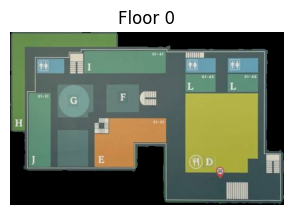

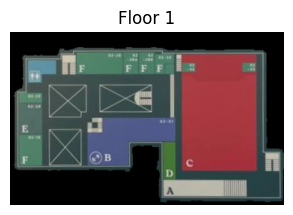

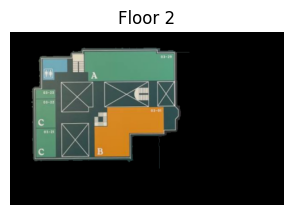

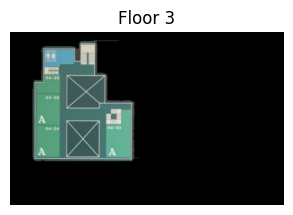

In [98]:
VidaCity2 = floorPlanBuilder(acutal_images)
# VidaCity2.createOverlay()
VidaCity2.createBuilding()
VidaCity2.plotBuilding()

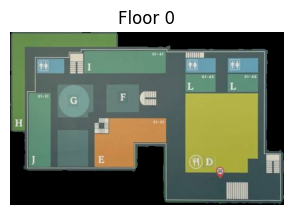

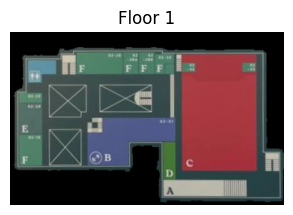

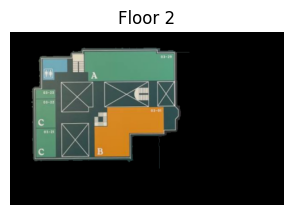

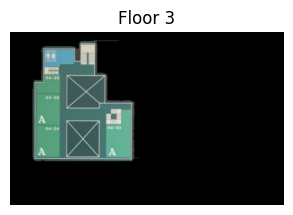

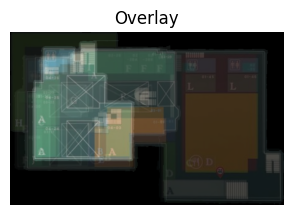

In [99]:
VidaCity2.plotBuilding()
VidaCity2.createOverlay()
VidaCity2.plotOverlay()

NGL, How did the above give me rgb image

### OCR Stuff

[2025/03/13 15:50:51] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\yongl/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\yongl/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320',

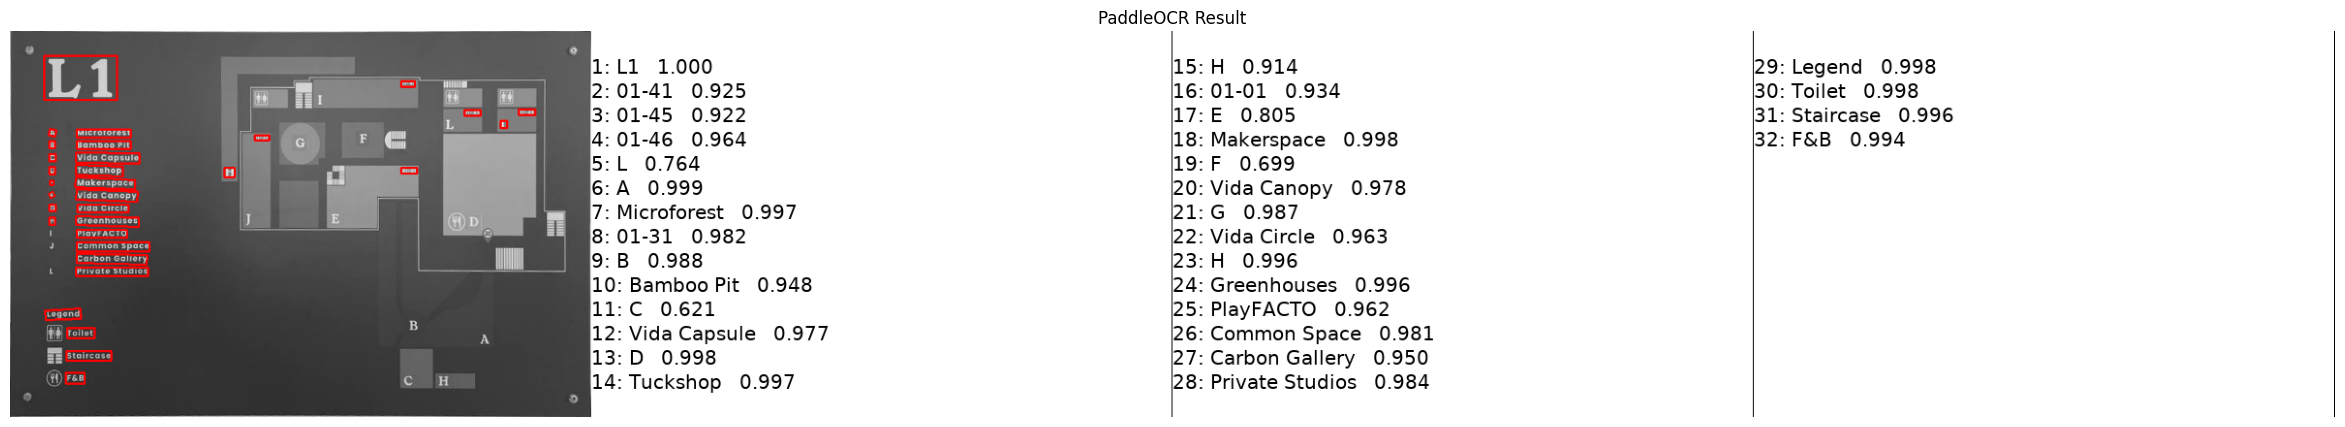

In [20]:
from paddleocr import PaddleOCR, draw_ocr
import cv2
import matplotlib.pyplot as plt

# Initialize the OCR model
ocr = PaddleOCR(use_angle_cls=True, lang="en")

# Suppose 'image' is already loaded via OpenCV (BGR format)
# image = cv2.imread("path/to/your_image.jpg")
# Or in your case: 
image = focused_images[0]
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
enhanced_gray = cv2.convertScaleAbs(gray, alpha=1, beta=0.9)


result = ocr.ocr(enhanced_gray, cls=True)

# The result can be nested: [ [ [box, (text, score)], [box, (text, score)], ... ] ]
# Flatten the list if it’s nested
flattened_result = [res for line in result for res in line]

# Separate the data into boxes, text, and scores
boxes = [res[0] for res in flattened_result]
texts = [res[1][0] for res in flattened_result]
scores = [res[1][1] for res in flattened_result]

# Convert the image from BGR to RGB
image_rgb = cv2.cvtColor(enhanced_gray, cv2.COLOR_BGR2RGB)

# Now call draw_ocr with the parsed data
annotated_image = draw_ocr(
    image_rgb,
    boxes,
    texts,
    scores,
    font_path='DejaVuSans.ttf'  # Omit or specify a valid .ttf for non-ASCII
)

# Display the annotated image
plt.figure(figsize=(30, 8))
plt.imshow(annotated_image)
plt.axis("off")
plt.title("PaddleOCR Result")
plt.show()


In [ ]:
def split_image_by_legend_density(image, ocr_bounding_boxes, margin=10):
    """
    Splits an image into two parts:
      1. A 'legend' region enclosing the densest cluster of text bounding boxes.
      2. The remainder of the image (often the map).

    Parameters:
    -----------
    image : numpy.ndarray
        The original image in BGR format.
    ocr_bounding_boxes : list
        A list of bounding boxes from OCR, where each box is of the form:
        [ [x0, y0], [x1, y1], [x2, y2], [x3, y3] ].
    margin : int, optional
        Extra padding around the bounding rectangle for the legend area.

    Returns:
    --------
    legend_region : numpy.ndarray
        Cropped image containing the legend area.
    map_region : numpy.ndarray
        Cropped image containing the remaining area (the map).
    legend_rect : tuple
        (min_x, min_y, max_x, max_y) of the legend bounding rectangle in the original image.
    """

    # Collect all x, y coordinates from each OCR bounding box
    x_coords = []
    y_coords = []
    for box in ocr_bounding_boxes:
        for (x, y) in box:
            x_coords.append(x)
            y_coords.append(y)

    if not x_coords or not y_coords:
        # No bounding boxes found, return the original image as "map"
        return None, image, None

    # Compute the min/max boundaries
    min_x, max_x = int(min(x_coords)), int(max(x_coords))
    min_y, max_y = int(min(y_coords)), int(max(y_coords))

    # Add some margin
    min_x = max(min_x - margin, 0)
    min_y = max(min_y - margin, 0)
    max_x = min(max_x + margin, image.shape[1])
    max_y = min(max_y + margin, image.shape[0])

    # Crop the legend region
    legend_region = image[min_y:max_y, min_x:max_x]

    # Crop the map region
    # Here, we assume the legend is on the left side
    map_region = image[:, max_x:]  # from the legend's right boundary to the end

    return legend_region, map_region, (min_x, min_y, max_x, max_y)